# semantic segmentation of moles and melanomas

using ADIDI dataset.

homework for MIPT Deep Learning School





In [1]:
!wget https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar
get_ipython().system_raw("unrar x PH2Dataset.rar")

--2022-07-11 09:56:21--  https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/k88qukc20ljnbuo/PH2Dataset.rar [following]
--2022-07-11 09:56:21--  https://www.dropbox.com/s/raw/k88qukc20ljnbuo/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc1c308436d8d90e9acf55e2d037.dl.dropboxusercontent.com/cd/0/inline/Bo2NVdm2pCca6fzYjhejnSZPLvpgAnztKdvhWbPaiIbbsyrEglmTclw7rOZGyMOsaVxoy1xChIQUTO0FG68a7XqqGjf8HAeocYEe10YF9ODb_9b-Lw42xUXfKQVWQ4tMhOskZgebN3H4ahjwyOg9z0Jmv9tZvuiGYAp5ne6MtGpRHw/file# [following]
--2022-07-11 09:56:21--  https://uc1c308436d8d90e9acf55e2d037.dl.dropboxusercontent.com/cd/0/inline/Bo2NVdm2pCca6fzYjhejnSZPLvpgAnztKdvhWbPaiIbbsyrEglmTclw7rOZGyM

In [2]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))



c помощью skimage изменим размеры каждой картинки

In [3]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [4]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [5]:
len(lesions)

200


нарисуем несколько изображений

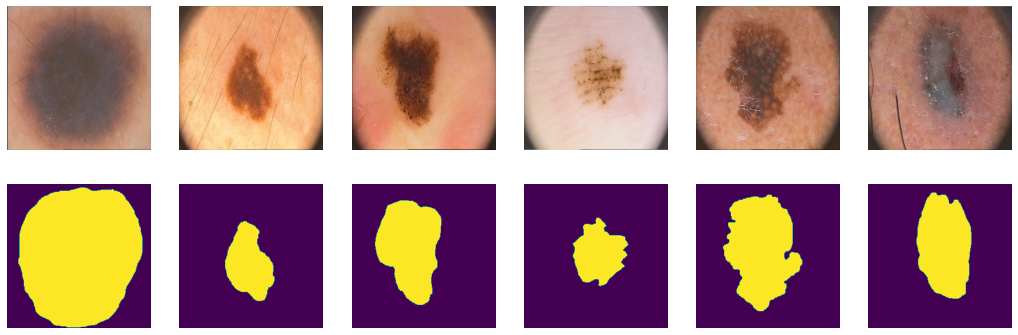

In [6]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 150/50 для обучения и валидации

In [7]:
ix = np.random.choice(len(X), len(X), False)
tr, val = np.split(ix, [150,])

In [8]:
print(len(tr), len(val))

150 50


#### PyTorch DataLoader

In [9]:
from torch.utils.data import DataLoader
batch_size = 5
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)

In [10]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #испольлзуем видеоускоритель если доступен
print(device)

cuda


SegNet


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torch import optim
from time import time

from matplotlib import rcParams
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = (15,4)

сверточные слои


In [12]:
def conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding = 1),
        nn.BatchNorm2d(out_channels),
        )

def conv_relu(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding = 1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(True),
        )
    
def double_conv_relu(in_channels, out_channels):
    return nn.Sequential(
        conv_relu(in_channels, out_channels),
        conv_relu(out_channels, out_channels),
        )
    
def triple_conv_relu(in_channels, out_channels):
    return nn.Sequential(
        conv_relu(in_channels, out_channels),
        conv_relu(out_channels, out_channels),
        conv_relu(out_channels, out_channels),
        )


In [13]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder_pool = nn.MaxPool2d(2, 2, return_indices = True)
        self.decoder_unpool = nn.MaxUnpool2d(2, 2)

        self.encoder_layer_1 = double_conv_relu(3, 64)
        self.encoder_layer_2 = double_conv_relu(64, 128)
        self.encoder_layer_3 = triple_conv_relu(128, 256)
        self.encoder_layer_4 = triple_conv_relu(256, 512)
        self.encoder_layer_5 = triple_conv_relu(512, 512)

        self.decoder_layer_5 = triple_conv_relu(512, 512)
        self.decoder_layer_4 = triple_conv_relu(512, 256)
        self.decoder_layer_3 = triple_conv_relu(256, 128)
        self.decoder_layer_2 = double_conv_relu(128, 64)
        self.decoder_layer_1 = nn.Sequential(conv_relu(64, 64), conv(64, 1),)

    def forward(self, x):
        y = self.encoder_layer_1(x)
        y, i1 = self.encoder_pool(y)
        y = self.encoder_layer_2(y)
        y, i2 = self.encoder_pool(y)
        y = self.encoder_layer_3(y)
        y, i3 = self.encoder_pool(y)
        y = self.encoder_layer_4(y)
        y, i4 = self.encoder_pool(y)
        y = self.encoder_layer_5(y)
        y, i5 = self.encoder_pool(y)

        y = self.decoder_unpool(y, i5)
        y = self.decoder_layer_5(y)
        y = self.decoder_unpool(y, i4)
        y = self.decoder_layer_4(y)
        y = self.decoder_unpool(y, i3)
        y = self.decoder_layer_3(y)
        y = self.decoder_unpool(y, i2)
        y = self.decoder_layer_2(y)
        y = self.decoder_unpool(y, i1)
        y = self.decoder_layer_1(y)

        return y


## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


In [14]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    outputs = outputs.squeeze(1).byte()
    labels = labels.squeeze(1).byte()
    intersection = (outputs & labels).float().sum((1, 2))
    union = (outputs | labels).float().sum((1, 2))  
    iou = (intersection + 1e-8) / (union + 1e-8)   
    return torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10
    

In [15]:
def bce_loss(y_real, y_pred): #функция потерь, бинарная кросс-энтропия
    loss = F.relu(y_pred) - y_real * y_pred + F.softplus(-torch.abs(y_pred))
    return torch.mean(loss)


train




In [16]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    loss_tr = []
    loss_val = []

    for epoch in range(epochs):
        print('* Epoch %d/%d' % (epoch+1, epochs))
        avg_train_loss = 0
        avg_val_loss = 0

        model.train()
        for X_batch, Y_batch in data_tr:
            X_batch, Y_batch = X_batch.cuda(), Y_batch.cuda()
            opt.zero_grad()
            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch, Y_pred)
            loss.backward()
            opt.step()
            avg_train_loss += loss.item() / len(data_tr)
        print('loss: %f' % avg_train_loss)
        loss_tr.append(avg_train_loss)

        model.eval()
        for X_val, Y_val in data_val:
            X_val = X_val.cuda()
            Y_pred = model(X_val).detach().cpu()
            loss = loss_fn(Y_val, Y_pred)
            Y_pred = torch.squeeze(Y_pred)
            Y_pred = (torch.sigmoid(Y_pred) > 0.5).type(torch.float)
            avg_val_loss += loss.item() / len(data_val)

            clear_output(wait = True)
            for k in range(5):
                plt.subplot(3, 5, k + 1)
                plt.imshow(np.rollaxis(X_val[k].cpu().numpy(), 0, 3))
                plt.title('Real')
                plt.axis('off')

                plt.subplot(3, 5, k + 6)
                plt.imshow(Y_val[k, 0], cmap = 'gray')
                plt.title('Label')
                plt.axis('off')

                plt.subplot(3, 5, k + 11)
                plt.imshow(Y_pred[k], cmap = 'gray')
                plt.title('Output')
                plt.axis('off')
            plt.suptitle(
                '%d / %d - loss: %f' % (epoch + 1, epochs, avg_val_loss)
                )
            plt.show()
        loss_val.append(avg_val_loss)
    return (loss_tr, loss_val)

оценка качества обучения

In [17]:
def score_model(model, metric, data):
    model.eval()
    scores = 0
    for X_batch, label in data:
        X_batch = X_batch.cuda()
        pred = torch.squeeze(model(X_batch).detach().cpu())
        pred = (torch.sigmoid(pred) > 0.5).type(torch.float)
        scores += metric(pred, label).mean().item()
    return scores / len(data)

## Основной момент: обучение




In [18]:
def learn(model, loss, epochs, data_tr, data_val):
    optimizer = optim.AdamW(model.parameters(), lr = 1e-4)
    return train(model, optimizer, loss, epochs, data_tr, data_val)

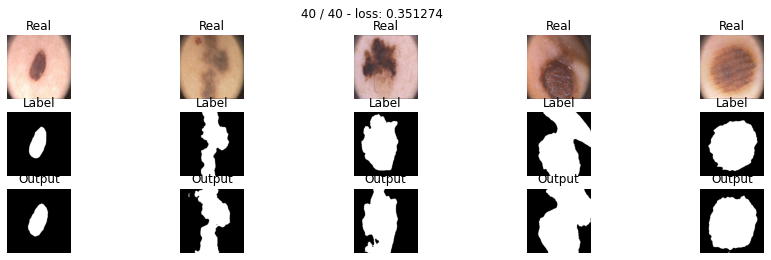

In [19]:
segnet_model_bce = SegNet().to(device)
segnet_bce_loss_tr, segnet_bce_loss_val = (
    learn(segnet_model_bce, bce_loss, 40, data_tr, data_val)
)

In [ ]:
score_segnet_bce = score_model(segnet_model_bce, iou_pytorch, data_val)
print(score_segnet_bce)

<Figure size 1080x288 with 0 Axes>

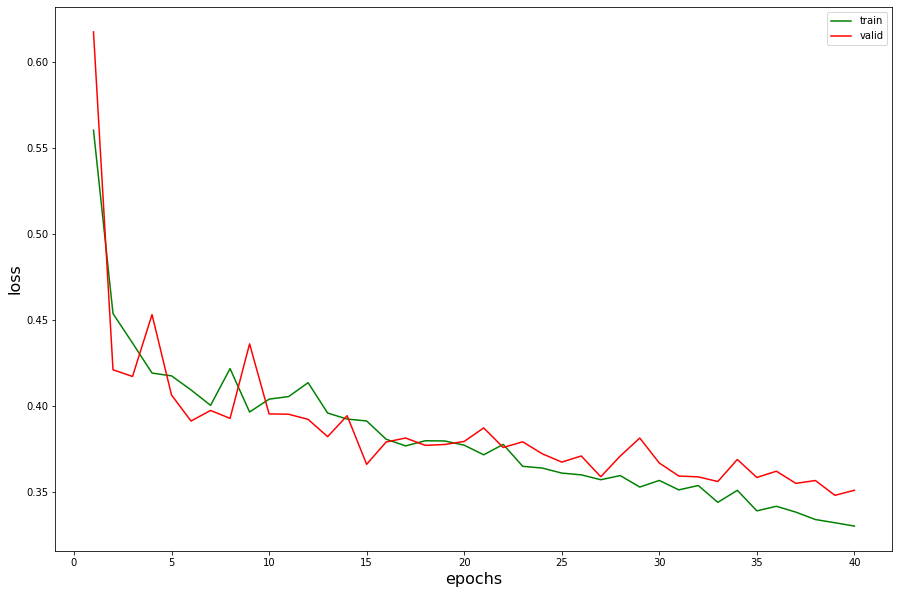

In [21]:
epochs = range(1, len(segnet_bce_loss_tr) + 1)

fig = plt.figure()

plt.figure(figsize = (15, 10))
plt.plot(epochs, segnet_bce_loss_tr, label = 'train', color = 'green')
plt.plot(epochs, segnet_bce_loss_val, label = 'valid', color = 'red')
plt.xlabel('epochs', fontsize = 16)
plt.ylabel('loss', fontsize = 16)
plt.legend()
plt.show()





Модель не переобучается

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь 


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$



In [22]:


def dice_loss(y_real, y_pred):
    y_pred = torch.sigmoid(y_pred)
    axes = tuple(range(1, len(y_pred.shape) - 1)) 
    numerator = 2. * torch.sum(y_pred * y_real, axes)
    denominator = torch.sum(y_pred + y_real, axes)
    return 1 - torch.mean((numerator + 1e-8) / (denominator + 1e-8))

Проводим тестирование:

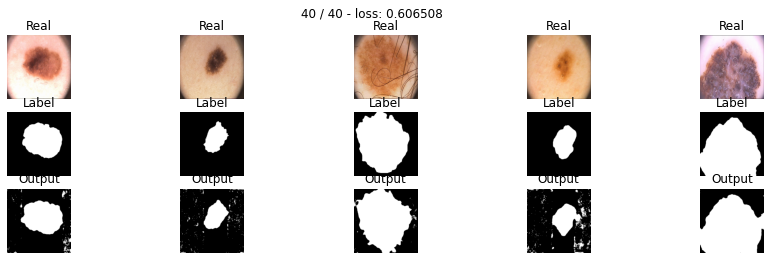

In [23]:
segnet_model_dice = SegNet().to(device)
segnet_dice_loss_tr, segnet_dice_loss_val = (
    learn(segnet_model_dice, dice_loss, 40, data_tr, data_val)
)

In [24]:
score_segnet_dice = score_model(segnet_model_dice, iou_pytorch, data_val)
print(score_segnet_dice)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


0.5819999992847442


<Figure size 1080x288 with 0 Axes>

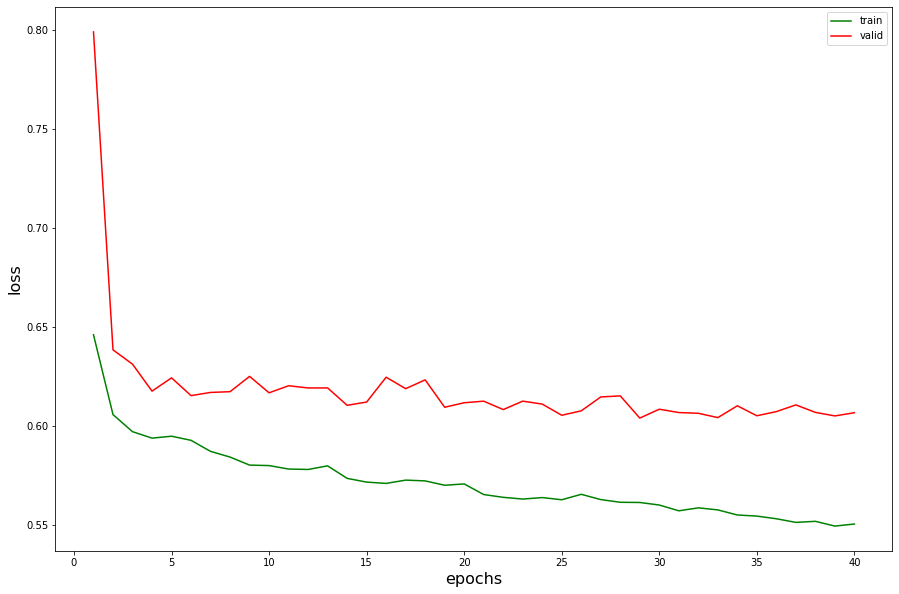

In [25]:
epochs = range(1, len(segnet_dice_loss_tr) + 1)

fig = plt.figure()

plt.figure(figsize = (15, 10))
plt.plot(epochs, segnet_dice_loss_tr, label = 'train', color = 'green')
plt.plot(epochs, segnet_dice_loss_val, label = 'valid', color = 'red')
plt.xlabel('epochs', fontsize = 16)
plt.ylabel('loss', fontsize = 16)
plt.legend()
plt.show()


In [35]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2): #задание со звездочкой

    bce = bce_loss(y_real, y_pred)
    return (1 - torch.exp(-bce)) ** gamma * bce


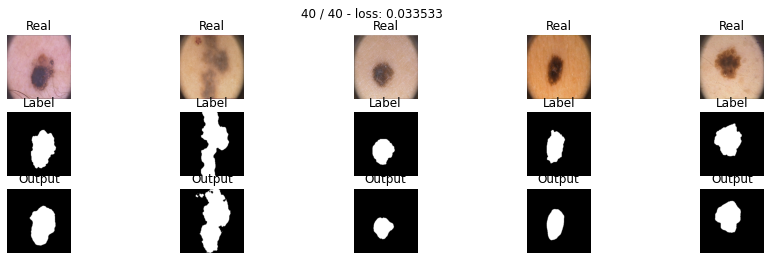

In [27]:
segnet_model_focal = SegNet().to(device)
segnet_focal_loss_tr, segnet_focal_loss_val = (
    learn(segnet_model_focal, focal_loss, 40, data_tr, data_val)
)

In [ ]:
score_segnet_focal = score_model(segnet_model_focal, iou_pytorch, data_val)
print(score_segnet_focal)

In [ ]:
epochs = range(1, len(segnet_focal_loss_tr) + 1)

fig = plt.figure()

plt.figure(figsize = (15, 10))
plt.plot(epochs, segnet_focal_loss_tr, label = 'train', color = 'green')
plt.plot(epochs, segnet_focal_loss_val, label = 'valid', color = 'red')
plt.xlabel('epochs', fontsize = 16)
plt.ylabel('loss', fontsize = 16)
plt.legend()
plt.show()


UNET


In [34]:
# https://github.com/mateuszbuda/brain-segmentation-pytorch/ - полезная ссылка

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool = nn.MaxPool2d(2, 2)

        self.encoder_layer_1 = double_conv_relu(3, 32)
        self.encoder_layer_2 = double_conv_relu(32, 64)
        self.encoder_layer_3 = double_conv_relu(64, 128)
        self.encoder_layer_4 = double_conv_relu(128, 256)
        self.encoder_layer_5 = double_conv_relu(256, 512)

        self.up_conv_5 = nn.ConvTranspose2d(512, 256, 2, 2)
        self.decoder_layer_5 = double_conv_relu(512, 256)
        self.up_conv_4 = nn.ConvTranspose2d(256, 128, 2, 2)
        self.decoder_layer_4 = double_conv_relu(256, 128)
        self.up_conv_3 = nn.ConvTranspose2d(128, 64, 2, 2)
        self.decoder_layer_3 = double_conv_relu(128, 64)
        self.up_conv_2 = nn.ConvTranspose2d(64, 32, 2, 2)
        self.decoder_layer_2 = double_conv_relu(64, 32)
        self.decoder_layer_1 = nn.Conv2d(32, 1, 1)        
       
    def forward(self, x):
        e1 = self.encoder_layer_1(x)
        y = self.pool(e1)
        e2 = self.encoder_layer_2(y)
        y = self.pool(e2)
        e3 = self.encoder_layer_3(y)
        y = self.pool(e3)
        e4 = self.encoder_layer_4(y)

        y = self.encoder_layer_5(self.pool(e4))

        y = torch.cat((self.up_conv_5(y), e4), dim = 1)
        y = self.decoder_layer_5(y)
        y = torch.cat((self.up_conv_4(y), e3), dim = 1)
        y = self.decoder_layer_4(y)
        y = torch.cat((self.up_conv_3(y), e2), dim = 1)
        y = self.decoder_layer_3(y)
        y = torch.cat((self.up_conv_2(y), e1), dim = 1)
        y = self.decoder_layer_2(y)

        return self.decoder_layer_1(y)


In [ ]:
unet_model_bce = UNet().to(device)
unet_bce_loss_tr, unet_bce_loss_val = (
    learn(unet_model_bce, bce_loss, 40, data_tr, data_val)
)

In [ ]:
score_unet_bce = score_model(unet_model_bce, iou_pytorch, data_val)
print(score_unet_bce)

In [ ]:
epochs = range(1, len(unet_bce_loss_tr) + 1)

fig = plt.figure()

plt.figure(figsize = (15, 10))
plt.plot(epochs, unet_bce_loss_tr, label = 'train', color = 'green')
plt.plot(epochs, unet_bce_loss_val, label = 'valid', color = 'red')
plt.xlabel('epochs', fontsize = 16)
plt.ylabel('loss', fontsize = 16)
plt.legend()
plt.show()


UNet c функцией потерь FocalLoss. 

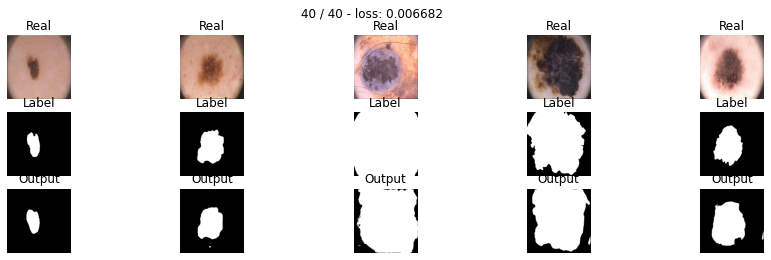

In [37]:
unet_model_focal = UNet().to(device)
unet_focal_loss_tr, unet_focal_loss_val = (
    learn(unet_model_focal, focal_loss, 40, data_tr, data_val)
)

In [38]:
score_unet_focal = score_model(unet_model_focal, iou_pytorch, data_val)
print(score_unet_focal)

0.7400000095367432


<Figure size 1080x288 with 0 Axes>

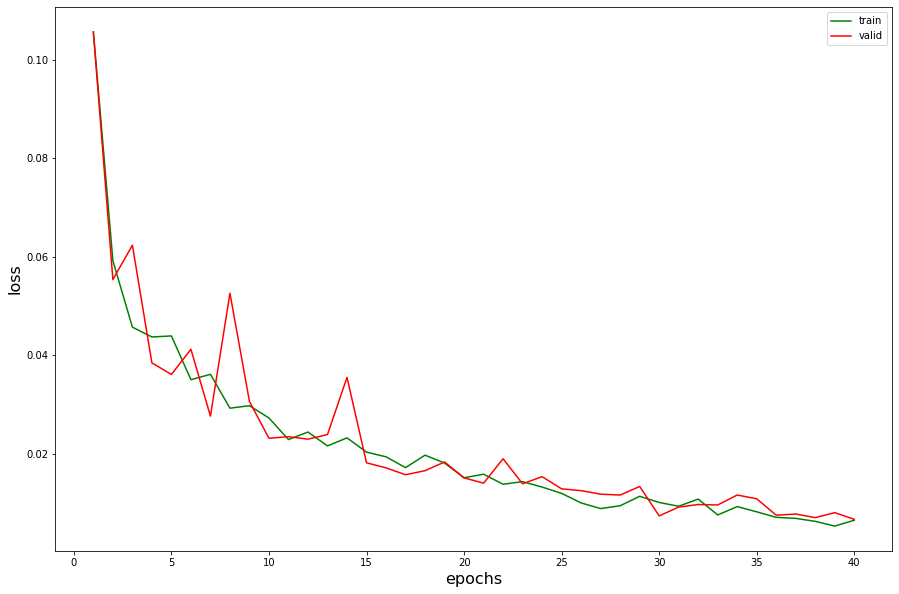

In [39]:
epochs = range(1, len(unet_focal_loss_tr) + 1)

fig = plt.figure()

plt.figure(figsize = (15, 10))
plt.plot(epochs, unet_focal_loss_tr, label = 'train', color = 'green')
plt.plot(epochs, unet_focal_loss_val, label = 'valid', color = 'red')
plt.xlabel('epochs', fontsize = 16)
plt.ylabel('loss', fontsize = 16)
plt.legend()
plt.show()
